In [1]:
!pip install kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [3]:
!kaggle datasets download -d kazanova/sentiment140

Dataset URL: https://www.kaggle.com/datasets/kazanova/sentiment140
License(s): other
 91% 74.0M/80.9M [00:00<00:00, 139MB/s]
100% 80.9M/80.9M [00:00<00:00, 139MB/s]


In [4]:
from zipfile import ZipFile
dataset = '/content/sentiment140.zip'

with ZipFile(dataset,'r') as zip:
  zip.extractall()
  print('The dataset is extracted')

The dataset is extracted


In [5]:
import numpy as np
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score

In [6]:
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',encoding='ISO-8859-1')

In [7]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [8]:
print(stopwords.words('english'))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [9]:
twitter_data.shape

(1599999, 6)

In [10]:
twitter_data.head()

,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer. You shoulda got David Carr of Third Day to do it. ;D"
0,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
1,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
2,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
3,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."
4,0,1467811372,Mon Apr 06 22:20:00 PDT 2009,NO_QUERY,joy_wolf,@Kwesidei not the whole crew


In [11]:
column_names=['target','id','date','flag','user','text']
twitter_data=pd.read_csv('/content/training.1600000.processed.noemoticon.csv',names=column_names,encoding='ISO-8859-1')

In [12]:
twitter_data.head()

,target,id,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


In [13]:
twitter_data.isnull().sum()

,0
target,0
id,0
date,0
flag,0
user,0
text,0


In [14]:
twitter_data['target'].value_counts()

,count
target,
0,800000
4,800000


In [15]:
twitter_data.replace({'target':{4:1}},inplace=True)

In [16]:
twitter_data['target'].value_counts()

,count
target,
0,800000
1,800000


In [17]:
port_stem=PorterStemmer()

In [18]:
def stemming(content):
  stemmed_content=re.sub('[^a-zA-Z]',' ',content)
  stemmed_content=stemmed_content.lower()
  stemmed_content=stemmed_content.split()
  stemmed_content=[port_stem.stem(word) for word in stemmed_content if not word in stopwords.words('english')]
  stemmed_content=' '.join(stemmed_content)
  return stemmed_content

In [ ]:
twitter_data['stemmed_content']=twitter_data['text'].apply(stemming)

In [ ]:
twitter_data.head()

In [ ]:
print(twitter_data['stemmed_content'])

In [ ]:
print(twitter_data['target'])

In [ ]:
X=twitter_data['stemmed_content'].values
Y=twitter_data['target'].values

In [ ]:
print(X)
print(Y)

['switchfoot http twitpic com zl awww bummer shoulda got david carr third day'
 'upset updat facebook text might cri result school today also blah'
 'kenichan dive mani time ball manag save rest go bound' ...
 'readi mojo makeov ask detail'
 'happi th birthday boo alll time tupac amaru shakur'
 'happi charitytuesday thenspcc sparkschar speakinguph h']
[0 0 0 ... 1 1 1]


In [ ]:
X_train,X_test,Y_train,Y_test=train_test_split(X,Y,test_size=0.2,stratify=Y,random_state=2)
print(X.shape,X_train.shape,X_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(Y.shape,Y_train.shape,Y_test.shape)

(1600000,) (1280000,) (320000,)


In [ ]:
print(X_train)

['watch saw iv drink lil wine' 'hatermagazin'
 'even though favourit drink think vodka coke wipe mind time think im gonna find new drink'
 ... 'eager monday afternoon'
 'hope everyon mother great day wait hear guy store tomorrow'
 'love wake folger bad voic deeper']


In [ ]:
print(X_test)

['mmangen fine much time chat twitter hubbi back summer amp tend domin free time'
 'ah may show w ruth kim amp geoffrey sanhueza'
 'ishatara mayb bay area thang dammit' ...
 'destini nevertheless hooray member wonder safe trip' 'feel well'
 'supersandro thank']


In [ ]:
vectorizer=TfidfVectorizer()
X_train=vectorizer.fit_transform(X_train)
X_test=vectorizer.transform(X_test)

In [ ]:
print(X_train)

  (0, 436713)	0.27259876264838384
  (0, 354543)	0.3588091611460021
  (0, 185193)	0.5277679060576009
  (0, 109306)	0.3753708587402299
  (0, 235045)	0.41996827700291095
  (0, 443066)	0.4484755317023172
  (1, 160636)	1.0
  (2, 109306)	0.4591176413728317
  (2, 124484)	0.1892155960801415
  (2, 407301)	0.18709338684973031
  (2, 129411)	0.29074192727957143
  (2, 406399)	0.32105459490875526
  (2, 433560)	0.3296595898028565
  (2, 77929)	0.31284080750346344
  (2, 443430)	0.3348599670252845
  (2, 266729)	0.24123230668976975
  (2, 409143)	0.15169282335109835
  (2, 178061)	0.1619010109445149
  (2, 150715)	0.18803850583207948
  (2, 132311)	0.2028971570399794
  (2, 288470)	0.16786949597862733
  (3, 406399)	0.29029991238662284
  (3, 158711)	0.4456939372299574
  (3, 151770)	0.278559647704793
  (3, 56476)	0.5200465453608686
  :	:
  (1279996, 318303)	0.21254698865277744
  (1279996, 434014)	0.27189450523324465
  (1279996, 390130)	0.2206474219107611
  (1279996, 373144)	0.35212500999832036
  (1279996, 23807

In [ ]:
model=LogisticRegression(max_iter=1000)

In [ ]:
model.fit(X_train,Y_train)

LogisticRegression(max_iter=1000)

In [ ]:
X_train_prediction=model.predict(X_train)
training_data_accuracy=accuracy_score(Y_train,X_train_prediction)

In [ ]:
print('Accuracy score on the training data: ',training_data_accuracy)

Accuracy score on the training data:  0.79871953125


In [ ]:
X_test_prediction=model.predict(X_test)
test_data_accuracy=accuracy_score(Y_test,X_test_prediction)

In [ ]:
print('Accuracy score on the test data: ',test_data_accuracy)

Accuracy score on the test data:  0.77668125


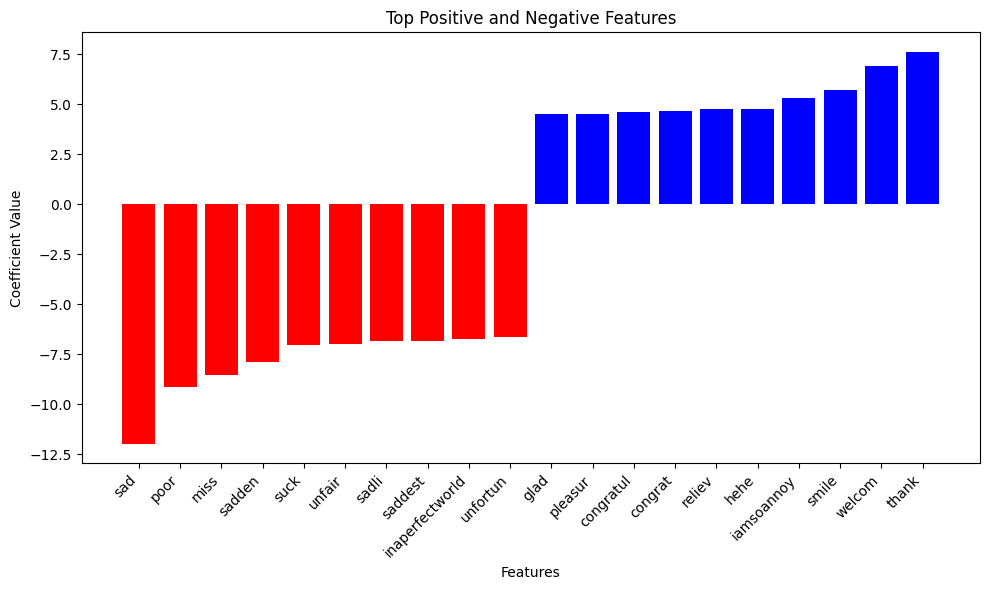

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

coefficients = model.coef_[0]
feature_names = vectorizer.get_feature_names_out()
top_n = 10
top_positive_indices = np.argsort(coefficients)[-top_n:]
top_negative_indices = np.argsort(coefficients)[:top_n]
top_indices = np.concatenate([top_negative_indices, top_positive_indices])
top_features = np.array(feature_names)[top_indices]
top_coefficients = coefficients[top_indices]
plt.figure(figsize=(10, 6))
plt.bar(top_features, top_coefficients, color=['red'] * top_n + ['blue'] * top_n)
plt.xticks(rotation=45, ha='right')
plt.xlabel('Features')
plt.ylabel('Coefficient Value')
plt.title('Top Positive and Negative Features')
plt.tight_layout()
plt.show()
